<a href="https://colab.research.google.com/github/ann04ka/Labs/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [1]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [2]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [3]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [4]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, action, reward, state2, action2, done):
    if done:
        target = reward
    else:
        target = reward + gamma * Q[state2, action2]

    Q[state, action] = Q[state, action] + lr_rate * (
        target - Q[state, action]
    )

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [11]:
from tqdm import tqdm
# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

wins = []
five_in_a_row = -1
recent_wins = [0] * 5

#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    won = 0
    while t < max_steps:
        t += 1
        action = choose_action(state)
        state2, reward, done, info = env.step(action)

        if t == max_steps:
            done = True

        learn(state, state2, reward, action, done)

        state = state2

        if reward == 1.0:
            won = 1

        if done:
            break

    wins.append(won)

    recent_wins.append(won)
    recent_wins.pop(0)

    if sum(recent_wins) == 5 and five_in_a_row == -1:
        five_in_a_row = game + 1

100%|██████████| 10000/10000 [00:07<00:00, 1354.02it/s]


Вывод ответов при заданных параметрах

In [12]:
print("Количество побед в серии из 10 000 игр:", sum(wins))
print("Пять побед подряд впервые было одержано в игре:", five_in_a_row)

Количество побед в серии из 10 000 игр: 7914
Пять побед подряд впервые было одержано в игре: 885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [13]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

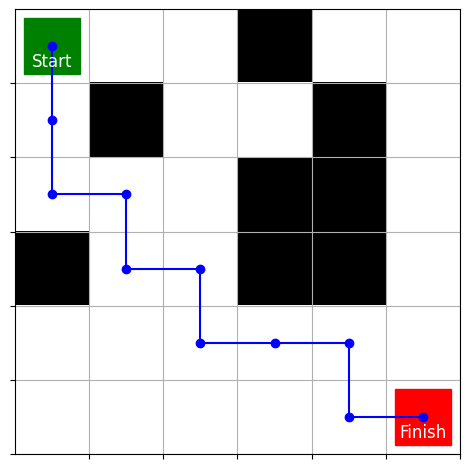

In [14]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [27]:
from tqdm import tqdm
import numpy as np

np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

wins = []
five_in_a_row = -1
recent_wins = [0] * 5

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state)
    won = 0

    while t < max_steps:
        t += 1

        state2, reward, done, info = env.step(action)

        action2 = choose_action(state2)

        if t == max_steps:
            done = True

        learn(state, action, reward, state2, action2, done)

        state = state2
        action = action2

        if reward == 1.0:
            won = 1

        if done:
            break

    wins.append(won)

    recent_wins.append(won)
    recent_wins.pop(0)

    if sum(recent_wins) == 5 and five_in_a_row == -1:
        five_in_a_row = game + 1

100%|██████████| 40000/40000 [00:32<00:00, 1245.41it/s]


In [28]:
print("Количество побед в серии из 10 000 игр:", sum(wins))
print("Пять побед подряд впервые было одержано в игре:", five_in_a_row)

Количество побед в серии из 10 000 игр: 32328
Пять побед подряд впервые было одержано в игре: 894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

## Исследуем влияние параметров gamma, lr_rate, epsilon на обучение моделей

In [10]:
def learn(Q, state, action, reward, state2, action2, done):
    if done:
        target = reward
    else:
        target = reward + gamma * Q[state2, action2]

    Q[state, action] = Q[state, action] + lr_rate * (target - Q[state, action])

In [85]:
def run_experiment(params, total_games=40000):
    gamma, lr_rate, epsilon = params
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    wins = []
    recent_wins = [0] * 100
    win_rates = []

    for game in range(total_games):
        state = env.reset()
        action = choose_action(state)
        done = False

        while not done:
            state2, reward, done, _ = env.step(action)
            action2 = choose_action(state2)
            learn(Q, state, action, reward, state2, action2, done)
            state = state2
            action = action2
            if reward == 1.0:
                break

        won = 1 if reward == 1.0 else 0
        wins.append(won)

        recent_wins.append(won)
        recent_wins.pop(0)

        if (game + 1) % 100 == 0:
            win_rates.append(sum(recent_wins) / len(recent_wins))

    return win_rates

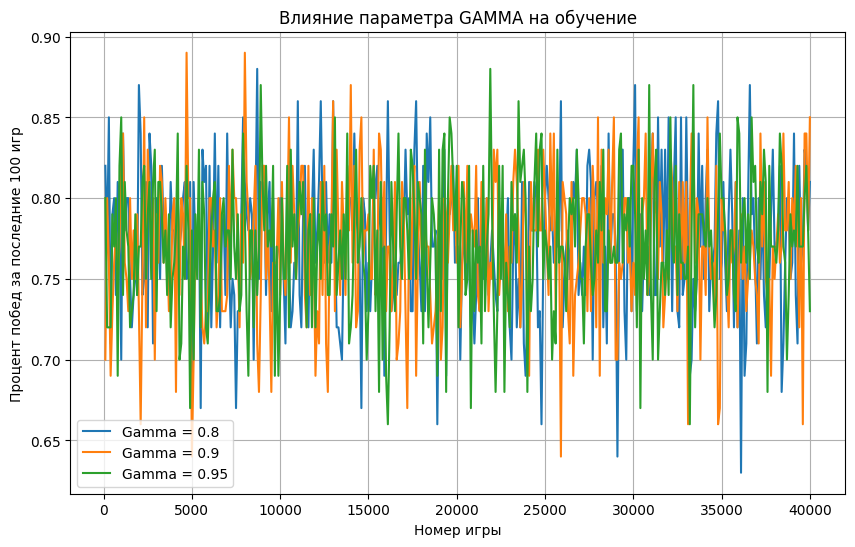

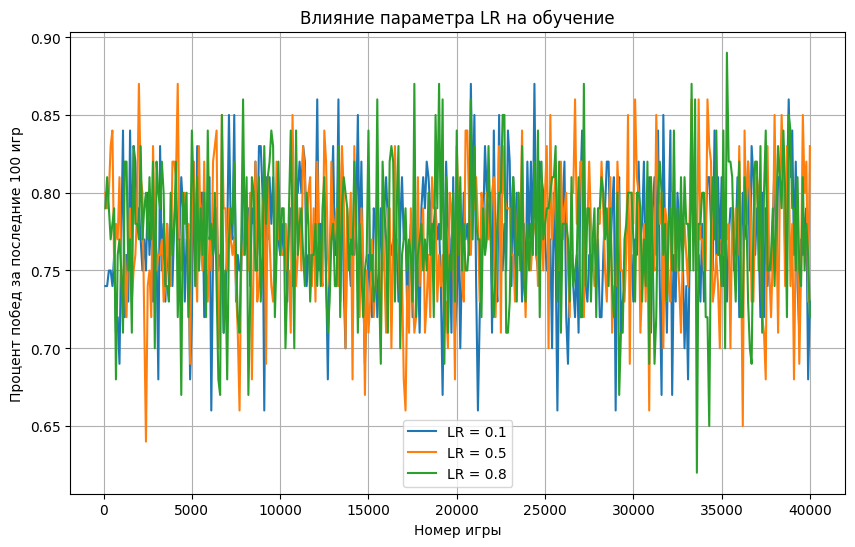

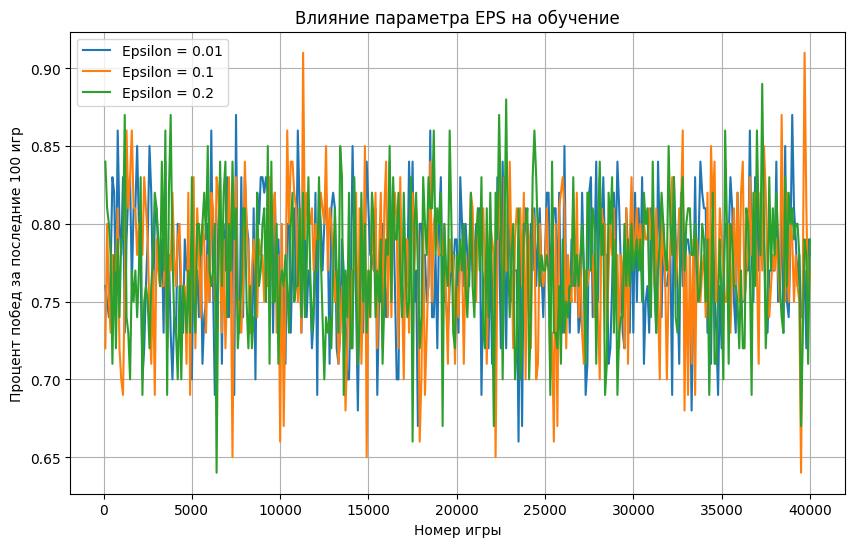

In [87]:
import matplotlib.pyplot as plt

param_sets = {
    'gamma': [(0.8, 0.8, 0.1), (0.9, 0.8, 0.1), (0.95, 0.8, 0.1)],
    'lr': [(0.95, 0.1, 0.1), (0.95, 0.5, 0.1), (0.95, 0.8, 0.1)],
    'eps': [(0.95, 0.8, 0.01), (0.95, 0.8, 0.1), (0.95, 0.8, 0.2)]
}

labels = {
    'gamma': ['Gamma = 0.8', 'Gamma = 0.9', 'Gamma = 0.95'],
    'lr': ['LR = 0.1', 'LR = 0.5', 'LR = 0.8'],
    'eps': ['Epsilon = 0.01', 'Epsilon = 0.1', 'Epsilon = 0.2']
}

for param_name in ['gamma', 'lr', 'eps']:
    results = []
    for params in param_sets[param_name]:
        result = run_experiment(params)
        results.append(result)

    plt.figure(figsize=(10, 6))
    for i, res in enumerate(results):
        plt.plot(range(100, 40001, 100), res, label=labels[param_name][i])
    plt.title(f'Влияние параметра {param_name.upper()} на обучение')
    plt.xlabel('Номер игры')
    plt.ylabel('Процент побед за последние 100 игр')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 1. **Влияние параметра `Gamma` (коэффициент дисконтирования)**:

- При `Gamma = 0.8`, динамика обучения менее стабильна и достигает меньших значений процента побед.
- При `Gamma = 0.9`, наблюдается умеренно стабильное поведение с периодическими пиковыми значениями.
- При `Gamma = 0.95`, обучение демонстрирует лучшую стабильность и более высокие средние значения процента побед.

Увеличение значения `Gamma` способствует большему учету будущих наград, что приводит к более долгосрочному планированию и, как правило, к лучшей производительности агента. Однако слишком высокое значение может замедлить обучение.

---

#### 2. **Влияние параметра `LR` (learning rate)**:

  - При `LR = 0.1`, обучение происходит медленнее, но более стабильно, с низким уровнем флуктуаций.
  - При `LR = 0.5`, наблюдаются более резкие изменения в процентах побед, указывающие на более быстрое адаптирование, но также повышенную нестабильность.
  - При `LR = 0.8`, обучение становится очень нестабильным, с большим количеством пиков и провалов.

Высокий learning rate ускоряет процесс обучения, но может привести к чрезмерной нестабильности и потере ранее полученных знаний. Оптимальный learning rate обеспечивает баланс между скоростью обучения и стабильностью.

---

#### 3. **Влияние параметра `Epsilon` (epsilon-greedy)**:

- При `Epsilon = 0.01`, обучение начинается медленно из-за недостаточной exploration, но со временем достигает стабильных высоких значений.
- При `Epsilon = 0.1`, обучение происходит более быстро благодаря достаточному уровню exploration, но иногда наблюдается некоторая нестабильность.
- При `Epsilon = 0.2`, обучение сильно зависит от случайных действий, что приводит к высокой нестабильности и снижению эффективности.

Низкий `Epsilon` гарантирует более стабильное обучение, но может замедлить его из-за недостаточной exploration. Средний уровень `Epsilon` обеспечивает оптимальный баланс между exploration и exploitation.

---

### Выводы:
1. **Gamma**:
   - Большее значение `Gamma` (например, 0.95) способствует лучшему долгосрочному планированию и стабильности обучения.
   
2. **Learning Rate**:
   - Оптимальный learning rate (например, 0.5) обеспечивает быстрое обучение без чрезмерной нестабильности.
   
3. **Epsilon**:
   - Средний уровень `Epsilon` (например, 0.1) гарантирует хороший баланс между exploration и exploitation.


# Альтернативные стратегии выбора действий

In [11]:
def choose_action_softmax(state, Q, T=0.5):
    logits = Q[state] / T
    logits -= np.max(logits)
    probs = np.exp(logits) / np.sum(np.exp(logits))
    return np.random.choice(len(probs), p=probs)

In [12]:
gamma = 0.95
lr_rate = 0.5

total_games = 40000
temperatures = [0.01, 0.05, 0.1] #, 0.5, 1.0, 2.0

best_T = None
best_win_rate = 0
results = {}
results_softmax = {}

for T in temperatures:
    print(f"Тестирование Softmax с T={T}")
    Q_sm = np.zeros((env.observation_space.n, env.action_space.n))
    wins = []

    for game in range(total_games):
        state = env.reset()
        done = False

        while not done:
            action = choose_action_softmax(state, Q_sm, T)
            state2, reward, done, _ = env.step(action)
            action2 = choose_action_softmax(state2, Q_sm, T)
            learn(Q_sm, state, action, reward, state2, action2, done)
            state = state2
            if done:
                break

        wins.append(1 if reward == 1.0 else 0)

    results_softmax[f'softmax_T{T}'] = wins
    win_rate = sum(wins[-100:]) / 100
    if win_rate > best_win_rate:
        best_win_rate = win_rate
        best_T = T

print(f"Лучшая температура для Softmax: T = {best_T}")
results['softmax'] = results_softmax[f'softmax_T{best_T}']
print(f"Лучшая температура: T = {best_T}, win-rate = {best_win_rate:.2%}")

Тестирование Softmax с T=0.01
Тестирование Softmax с T=0.05
Тестирование Softmax с T=0.1
Лучшая температура для Softmax: T = 0.01
Лучшая температура: T = 0.01, win-rate = 100.00%


In [9]:
def choose_action_ucb(state, Q, counts, t, c=1.0):
    for a in range(Q.shape[1]):
        if counts[state, a] == 0:
            return a
    ucb = Q[state] + c * np.sqrt(np.log(t) / counts[state])
    return np.argmax(ucb)

In [14]:
lr_rate = 0.8
gamma = 0.95
total_games = 40000
cs = [1.5, 2.0, 3.0]

best_c = None
best_win_rate = 0
results_ucb = {}

for c in cs:
    print(f"Тестирование UCB с c={c}")
    Q_ucb = np.zeros((env.observation_space.n, env.action_space.n))
    counts = np.ones((env.observation_space.n, env.action_space.n))
    wins = []

    for game in range(total_games):
        state = env.reset()
        done = False
        t_episode = 1

        while not done:
            action = choose_action_ucb(state, Q_ucb, counts, t_episode, c)
            state2, reward, done, _ = env.step(action)
            action2 = choose_action_ucb(state2, Q_ucb, counts, t_episode + 1, c)

            learn(Q_ucb, state, action, reward, state2, action2, done)

            counts[state, action] += 1

            state = state2
            t_episode += 1

            if done:
                break

        wins.append(1 if reward == 1.0 else 0)

    results_ucb[f'ucb_c{c}'] = wins
    win_rate = sum(wins[-100:]) / 100
    if win_rate > best_win_rate:
        best_win_rate = win_rate
        best_c = c

print(f"Лучший c для UCB: c = {best_c}")
results['ucb'] = results_ucb[f'ucb_c{best_c}']
print(f"Лучший c: c = {best_c}, win-rate = {best_win_rate:.2%}")

Тестирование UCB с c=1.5
Тестирование UCB с c=2.0
Тестирование UCB с c=3.0
Лучший c для UCB: c = 1.5
Лучший c: c = 1.5, win-rate = 100.00%


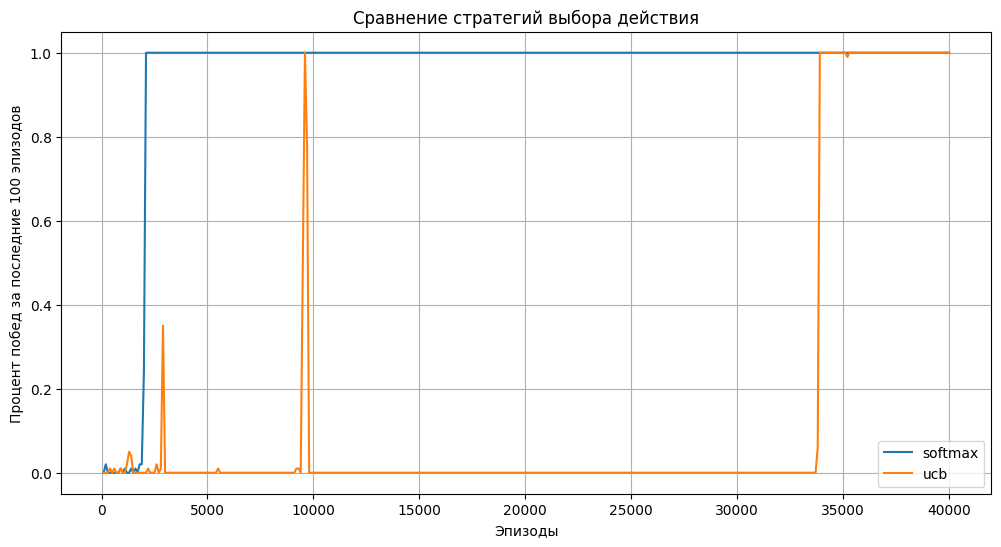

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for name, data in results.items():
    win_rates = [sum(data[i:i+100])/100 for i in range(0, len(data), 100)]
    plt.plot(range(100, total_games+1, 100), win_rates, label=name)

plt.title("Сравнение стратегий выбора действия")
plt.xlabel("Эпизоды")
plt.ylabel("Процент побед за последние 100 эпизодов")
plt.legend()
plt.grid(True)
plt.show()

В ходе экспериментов были протестированы две стратегии выбора действий — **Softmax** и **UCB** — с подбором гиперпараметров (`T` для Softmax и `c` для UCB). Обе стратегии в конечном итоге достигли **100% win-rate** за 40 000 эпизодов, что говорит об их способности к обучению в данной задаче.

Однако скорость сходимости у стратегий оказалась разной:
- **Softmax**: стабильный win-rate (~100%) был достигнут примерно на **2 000 шаге**.
- **UCB**: аналогичный результат был достигнут значительно позже — около **34 000 шага**.

**Softmax сходится быстрее** в условиях текущей среды `FrozenLake-v0`

---

## Softmax
- Позволяет агенту равномерно исследовать действия на ранних этапах, особенно при правильной настройке температуры `T`.
- После начального exploration алгоритм переходит к exploitation наиболее успешных действий, что способствует быстрому обучению.
- Подходит для сред с чётко выраженной "лучшей" политикой, как в случае детерминированного `FrozenLake`.

## UCB
- Делает акцент на исследованиях менее посещаемых состояний и действий, что замедляет сходимость.
- Механизм upper confidence bound полезен в стохастических или сложных средах, где важно избегать преждевременной фокусировки на локальных максимумах.
- В детерминированной среде `FrozenLake` этот механизм оказывается избыточным и требует больше времени для выхода к оптимальной политике.

---

## Гиперпараметры

- Для **Softmax** ключевым параметром является **температура `T`**:
  - При слишком высоких значениях происходит избыточный exploration.
  - При слишком низких — алгоритм быстро переходит к exploitation и может застрять на подоптимальной политике.
  - В данной задаче низкая температура `T = 0.01` позволила быстро достичь 100% win-rate.

- Для **UCB** важен параметр **`c`**, регулирующий степень exploration:
  - Лучшим оказалось наименьшее значение `c = 1.5`, возможно не стоило при выборе исследуемого диапозона опираться на меточку.

---

## Выводы

**Softmax показал лучшие результаты по скорости сходимости** и оказался более подходящим для решения задачи `FrozenLake-v0`.

**UCB продемонстрировал потенциал, но потребовал гараздо больше времени для обучения**, что делает его менее эффективным в простых и детерминированных средах.
